Apply PCA to reduce dimensionality in modeling net migration into US counties.

Data come from [US Census](https://bit.ly/38PyfmR), [Income Inequality Data](https://www.census.gov/data/tables/time-series/demo/income-poverty/historical-income-households.html), [Bureau of Labor Statistics](https://www.bls.gov/lau/#tables), [Center for Disease Control and Prevention](https://wonder.cdc.gov/controller/datarequest/D77;jsessionid=8C4B35CF4C4E32D332C6B5CF02580AA7), [Community Commons](https://engagementnetwork.org/map-room/)

This notebook must be in the same folder as the [mobilityHelpers](https://www.dropbox.com/s/0m77gl9p58rpdx7/mobilityHelpers.ipynb?dl=0) notebook

In [1]:
%run ./mobilityHelpers.ipynb
helpers = mobilityHelpers()

gdpFile = helpers.mFiles["gdp"]
piFile = helpers.mFiles["pi"]
hhiFile = helpers.mFiles["hhi"]
populationFile = helpers.mFiles["pop"]
suicideFile = helpers.mFiles["sc"]
employFile = helpers.mFiles["emp"]
employFile

/anaconda3/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


'./../../ResearchProposal/unemployment/employment_by_county_state_year.csv'

In [2]:
empDF, empDFlong = helpers.getEmpData()
empDFlong.head()

,county,state,county_state,year,metric,value
0,Autauga,Alabama,"Autauga, Alabama",2000,LABOR_FORCE,21720.0
1,Baldwin,Alabama,"Baldwin, Alabama",2000,LABOR_FORCE,69533.0
2,Barbour,Alabama,"Barbour, Alabama",2000,LABOR_FORCE,11373.0
3,Bibb,Alabama,"Bibb, Alabama",2000,LABOR_FORCE,8565.0
4,Blount,Alabama,"Blount, Alabama",2000,LABOR_FORCE,25106.0


In [3]:
popDF, popDFlong = helpers.getPopulationDynamicsData()
popDF.head()
popDFlong.head()

,state,county,county_state,value,year,metric
0,Alabama,Autauga,"Autauga, Alabama",54571.0,2010,CENSUSPOP
1,Alabama,Baldwin,"Baldwin, Alabama",182265.0,2010,CENSUSPOP
2,Alabama,Barbour,"Barbour, Alabama",27457.0,2010,CENSUSPOP
3,Alabama,Bibb,"Bibb, Alabama",22915.0,2010,CENSUSPOP
4,Alabama,Blount,"Blount, Alabama",57322.0,2010,CENSUSPOP


In [4]:
gdpDF, gdpDFlong = helpers.getGDPdata()
gdpDF.head()
gdpDFlong.tail()

,county,state,value,year,metric,county_state
24835,Sweetwater,Wyoming,6.583947,2018,GDP_LOG,"Sweetwater, Wyoming"
24836,Teton,Wyoming,6.335743,2018,GDP_LOG,"Teton, Wyoming"
24837,Uinta,Wyoming,5.957409,2018,GDP_LOG,"Uinta, Wyoming"
24838,Washakie,Wyoming,5.554009,2018,GDP_LOG,"Washakie, Wyoming"
24839,Weston,Wyoming,5.499529,2018,GDP_LOG,"Weston, Wyoming"


In [5]:
hhiDF, hhiDFlong = helpers.getHouseholdIncomeData()
hhiDFlong.head()

,county,state,county_state,year,value,metric
0,Jersey,Illinois,"Jersey, Illinois",2010,1.173144,mean_to_median_household_income_ratio
1,Jo Daviess,Illinois,"Jo Daviess, Illinois",2010,1.224985,mean_to_median_household_income_ratio
2,Johnson,Illinois,"Johnson, Illinois",2010,1.163771,mean_to_median_household_income_ratio
3,Kane,Illinois,"Kane, Illinois",2010,1.274337,mean_to_median_household_income_ratio
4,Kankakee,Illinois,"Kankakee, Illinois",2010,1.208422,mean_to_median_household_income_ratio


In [6]:
scDF, scDFlong = helpers.getSuicideRateData()
# scDFlong.rename(columns={"variable": "metric"}, inplace=True)
scDFlong.head()

,county,state,county_state,year,metric,value
0,Baldwin,Alabama,"Baldwin, Alabama",2006,SCRATE,18.3
1,Calhoun,Alabama,"Calhoun, Alabama",2006,SCRATE,18.1
2,Jefferson,Alabama,"Jefferson, Alabama",2006,SCRATE,10.9
3,Madison,Alabama,"Madison, Alabama",2006,SCRATE,13.9
4,Mobile,Alabama,"Mobile, Alabama",2006,SCRATE,9.8


In [7]:
"""
concatenate hhi, gdp, pop, sc, and employment
"""
hhi_gdp_pop_sc_emp_long = pd.concat([gdpDFlong, hhiDFlong, popDFlong, scDFlong, empDFlong], sort=True).reset_index(drop=True)
hhi_gdp_pop_sc_emp_long.head()

,county,county_state,metric,state,value,year
0,Autauga,"Autauga, Alabama",GDP,Alabama,1518409.0,2015
1,Baldwin,"Baldwin, Alabama",GDP,Alabama,5345363.0,2015
2,Barbour,"Barbour, Alabama",GDP,Alabama,756590.0,2015
3,Bibb,"Bibb, Alabama",GDP,Alabama,358372.0,2015
4,Blount,"Blount, Alabama",GDP,Alabama,824934.0,2015


In [8]:
hhi_gdp_pop_sc_emp_long.tail()

,county,county_state,metric,state,value,year
820226,Vega Baja Municipio,"Vega Baja Municipio, Puerto Rico",UNEMPLOYMENT_RATE_PCT,Puerto Rico,9.6,2019
820227,Vieques Municipio,"Vieques Municipio, Puerto Rico",UNEMPLOYMENT_RATE_PCT,Puerto Rico,6.9,2019
820228,Villalba Municipio,"Villalba Municipio, Puerto Rico",UNEMPLOYMENT_RATE_PCT,Puerto Rico,15.9,2019
820229,Yabucoa Municipio,"Yabucoa Municipio, Puerto Rico",UNEMPLOYMENT_RATE_PCT,Puerto Rico,13.1,2019
820230,Yauco Municipio,"Yauco Municipio, Puerto Rico",UNEMPLOYMENT_RATE_PCT,Puerto Rico,14.6,2019


Now we have all the data: population dynamics (modeled by US Census Bureau); GDP; Household Income, and Suicide Rates.  Next we will apply ML methods to extract insights from these data.

In [9]:
hhi_gdp_pop_sc_emp_long["metric_year"] = hhi_gdp_pop_sc_emp_long["metric"] + hhi_gdp_pop_sc_emp_long["year"].astype("str")
hhi_gdp_pop_sc_emp_df = hhi_gdp_pop_sc_emp_long.pivot_table(index=["county_state"],
                                                    columns=["metric_year"],
                                                    values=["value"]).reset_index(drop=False)
hhi_gdp_pop_sc_emp_df.head()

county_state      value                        \
metric_year                            BIRTHS2010 BIRTHS2011 BIRTHS2012   
0            Abbeville, South Carolina       65.0      229.0      280.0   
1             Acadia Parish, Louisiana      212.0      870.0      879.0   
2                    Acadia, Louisiana        NaN        NaN        NaN   
3                   Accomack, Virginia       89.0      474.0      458.0   
4                           Ada, Idaho     1310.0     5150.0     5032.0   

                                                                               \
metric_year BIRTHS2013 BIRTHS2014 BIRTHS2015 BIRTHS2016 BIRTHS2017 BIRTHS2018   
0                273.0      242.0      247.0      227.0      217.0      237.0   
1                883.0      920.0      899.0      910.0      892.0      824.0   
2                  NaN        NaN        NaN        NaN        NaN        NaN   
3                345.0      381.0      405.0      380.0      363.0      401.0   
4               5043.0     4986.0     5186.0     5074.0     4937.0     4946.0   

             ...                                            \
metric_year  ... mean_to_median_household_income_ratio2018   
0            ...                                  1.403462   
1            ...                                  1.474464   
2            ...                                       NaN   
3            ...                                  1.342189   
4            ...                                  1.342082   

                                                                   \
metric_year median_income__dollars2010 median_income__dollars2011   
0                              33143.0                    34670.0   
1                              37261.0                    37970.0   
2                                  NaN                        NaN   
3                              41372.0                    41595.0   
4                              55835.0                    55304.0   

                                                                   \
metric_year median_income__dollars2012 median_income__dollars2013   
0                              35067.0                    35947.0   
1                              38686.0                    37587.0   
2                                  NaN                        NaN   
3                              40780.0                    39328.0   
4                              55499.0                    55210.0   

                                                                   \
metric_year median_income__dollars2014 median_income__dollars2015   
0                              35409.0                    34799.0   
1                              37684.0                    37649.0   
2                                  NaN                        NaN   
3                              39389.0                    39412.0   
4                              55805.0                    56356.0   

                                                                   \
metric_year median_income__dollars2016 median_income__dollars2017   
0                              34652.0                    35254.0   
1                              39837.0                    40492.0   
2                                  NaN                        NaN   
3                              38503.0                    42260.0   
4                              58099.0                    60151.0   

                                        
metric_year median_income__dollars2018  
0                              36685.0  
1                              41177.0  
2                                  NaN  
3                              43210.0  
4                              63137.0  

[5 rows x 304 columns]

In [10]:
cols = ["county_state"]
cols.extend(list(hhi_gdp_pop_sc_emp_df.columns.levels[1][:-1]))
hhi_gdp_pop_sc_emp_df.columns = cols
# hhi_gdp_pop_sc_emp_df.dropna(inplace=True)

hhi_gdp_pop_sc_emp_df.reset_index(drop=True, inplace=True)

print(hhi_gdp_pop_sc_emp_df.dtypes)

hhi_gdp_pop_sc_emp_df.head()

county_state                   object
BIRTHS2010                    float64
BIRTHS2011                    float64
BIRTHS2012                    float64
BIRTHS2013                    float64
                               ...   
median_income__dollars2014    float64
median_income__dollars2015    float64
median_income__dollars2016    float64
median_income__dollars2017    float64
median_income__dollars2018    float64
Length: 304, dtype: object


,county_state,BIRTHS2010,BIRTHS2011,BIRTHS2012,BIRTHS2013,BIRTHS2014,BIRTHS2015,BIRTHS2016,BIRTHS2017,BIRTHS2018,...,mean_to_median_household_income_ratio2018,median_income__dollars2010,median_income__dollars2011,median_income__dollars2012,median_income__dollars2013,median_income__dollars2014,median_income__dollars2015,median_income__dollars2016,median_income__dollars2017,median_income__dollars2018
0,"Abbeville, South Carolina",65.0,229.0,280.0,273.0,242.0,247.0,227.0,217.0,237.0,...,1.403462,33143.0,34670.0,35067.0,35947.0,35409.0,34799.0,34652.0,35254.0,36685.0
1,"Acadia Parish, Louisiana",212.0,870.0,879.0,883.0,920.0,899.0,910.0,892.0,824.0,...,1.474464,37261.0,37970.0,38686.0,37587.0,37684.0,37649.0,39837.0,40492.0,41177.0
2,"Acadia, Louisiana",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Accomack, Virginia",89.0,474.0,458.0,345.0,381.0,405.0,380.0,363.0,401.0,...,1.342189,41372.0,41595.0,40780.0,39328.0,39389.0,39412.0,38503.0,42260.0,43210.0
4,"Ada, Idaho",1310.0,5150.0,5032.0,5043.0,4986.0,5186.0,5074.0,4937.0,4946.0,...,1.342082,55835.0,55304.0,55499.0,55210.0,55805.0,56356.0,58099.0,60151.0,63137.0


In [11]:
yy=2010
yyDF = hhi_gdp_pop_sc_emp_df[[cc for cc in hhi_gdp_pop_sc_emp_df if str(yy) in cc]].copy()
for cc in yyDF.columns:
    yyDF[cc] = yyDF[cc].astype("float64")
print(yyDF.columns)
yyDF.head()

Index(['BIRTHS2010', 'CENSUSPOP2010', 'DEATHS2010', 'DOMESTICMIG2010',
       'EMPLOYED2010', 'ESTIMATESBASE2010', 'INTERNATIONALMIG2010',
       'LABOR_FORCE2010', 'NATURALINC2010', 'NETMIG2010', 'NPOPCHG_2010',
       'POPESTIMATE2010', 'POP_CDC2010', 'SCDEATHS2010', 'SCRATE2010',
       'SC_R_DEATH2010', 'UNEMPLOYED2010', 'UNEMPLOYMENT_RATE_PCT2010',
       'mean_income__dollars2010', 'mean_to_median_household_income_ratio2010',
       'median_income__dollars2010'],
      dtype='object')


,BIRTHS2010,CENSUSPOP2010,DEATHS2010,DOMESTICMIG2010,EMPLOYED2010,ESTIMATESBASE2010,INTERNATIONALMIG2010,LABOR_FORCE2010,NATURALINC2010,NETMIG2010,...,POPESTIMATE2010,POP_CDC2010,SCDEATHS2010,SCRATE2010,SC_R_DEATH2010,UNEMPLOYED2010,UNEMPLOYMENT_RATE_PCT2010,mean_income__dollars2010,mean_to_median_household_income_ratio2010,median_income__dollars2010
0,65.0,25417.0,90.0,-67.0,9439.0,25416.0,2.0,10925.0,-25.0,-65.0,...,25328.0,NaN,NaN,NaN,NaN,1486.0,13.6,41816.0,1.261684,33143.0
1,212.0,61773.0,112.0,-9.0,24233.0,61787.0,5.0,26130.0,100.0,-4.0,...,61877.0,NaN,NaN,NaN,NaN,1897.0,7.3,48844.0,1.310861,37261.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,89.0,33164.0,145.0,41.0,15479.0,33162.0,3.0,16805.0,-56.0,44.0,...,33148.0,NaN,NaN,NaN,NaN,1326.0,7.9,53240.0,1.286861,41372.0
4,1310.0,392365.0,485.0,137.0,180585.0,392372.0,60.0,196945.0,825.0,197.0,...,393354.0,392365.0,56.0,14.0,14.272425,16360.0,8.3,72123.0,1.291717,55835.0


Analyze correlations.  The machine does not need our visualizations, but it's good to see them to check how well it did.  In the plot below, the numbers on the X and Y axes represent the index of the corresponding column in the dataframe

Got 3407 rows for 2010


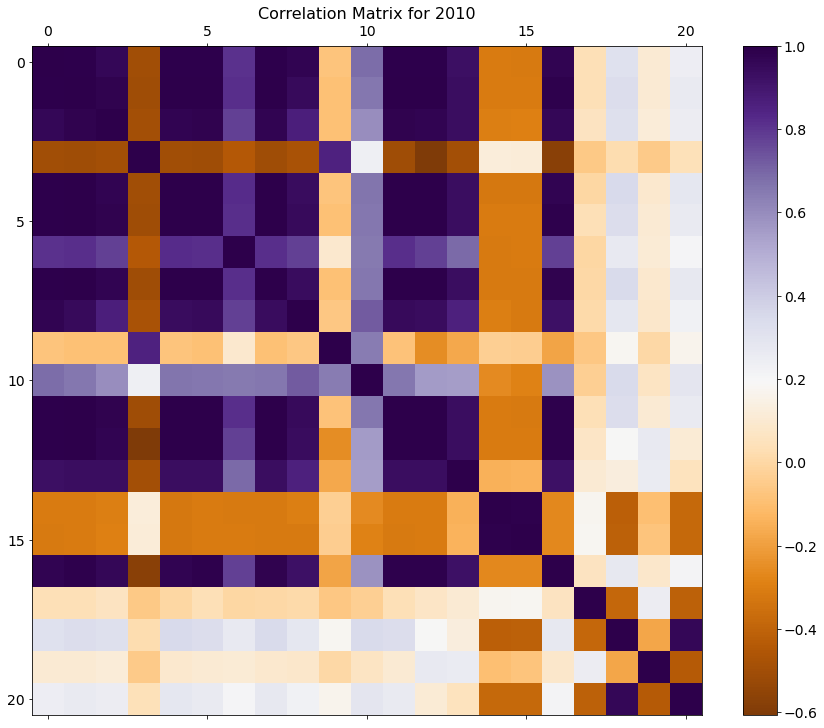

0: BIRTHS2010
1: CENSUSPOP2010
2: DEATHS2010
3: DOMESTICMIG2010
4: EMPLOYED2010
5: ESTIMATESBASE2010
6: INTERNATIONALMIG2010
7: LABOR_FORCE2010
8: NATURALINC2010
9: NETMIG2010
10: NPOPCHG_2010
11: POPESTIMATE2010
12: POP_CDC2010
13: SCDEATHS2010
14: SCRATE2010
15: SC_R_DEATH2010
16: UNEMPLOYED2010
17: UNEMPLOYMENT_RATE_PCT2010
18: mean_income__dollars2010
19: mean_to_median_household_income_ratio2010
20: median_income__dollars2010
Got 3407 rows for 2011


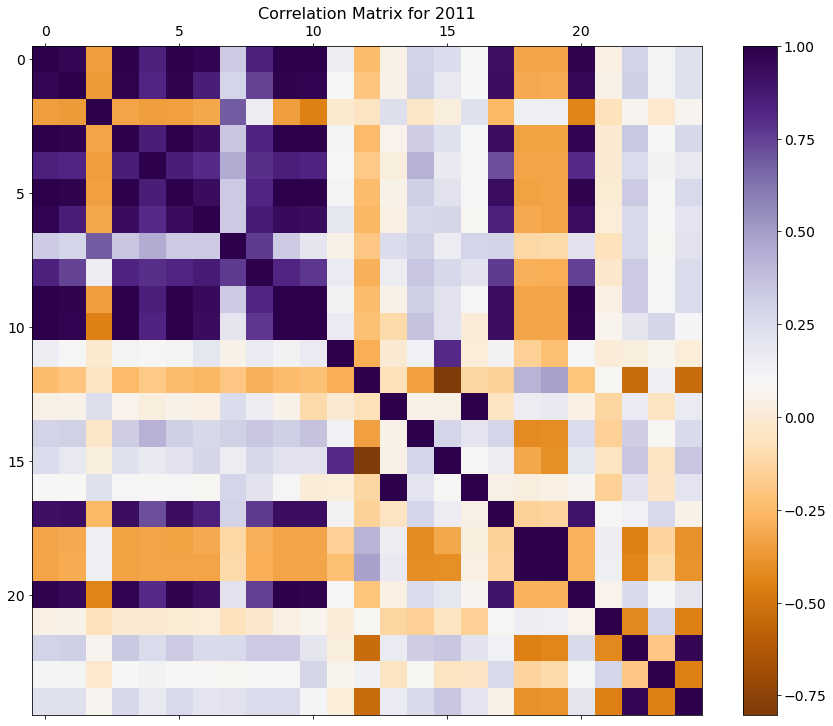

0: BIRTHS2011
1: DEATHS2011
2: DOMESTICMIG2011
3: EMPLOYED2011
4: INTERNATIONALMIG2011
5: LABOR_FORCE2011
6: NATURALINC2011
7: NETMIG2011
8: NPOPCHG_2011
9: POPESTIMATE2011
10: POP_CDC2011
11: RBIRTH2011
12: RDEATH2011
13: RDOMESTICMIG2011
14: RINTERNATIONALMIG2011
15: RNATURALINC2011
16: RNETMIG2011
17: SCDEATHS2011
18: SCRATE2011
19: SC_R_DEATH2011
20: UNEMPLOYED2011
21: UNEMPLOYMENT_RATE_PCT2011
22: mean_income__dollars2011
23: mean_to_median_household_income_ratio2011
24: median_income__dollars2011
Got 3407 rows for 2012


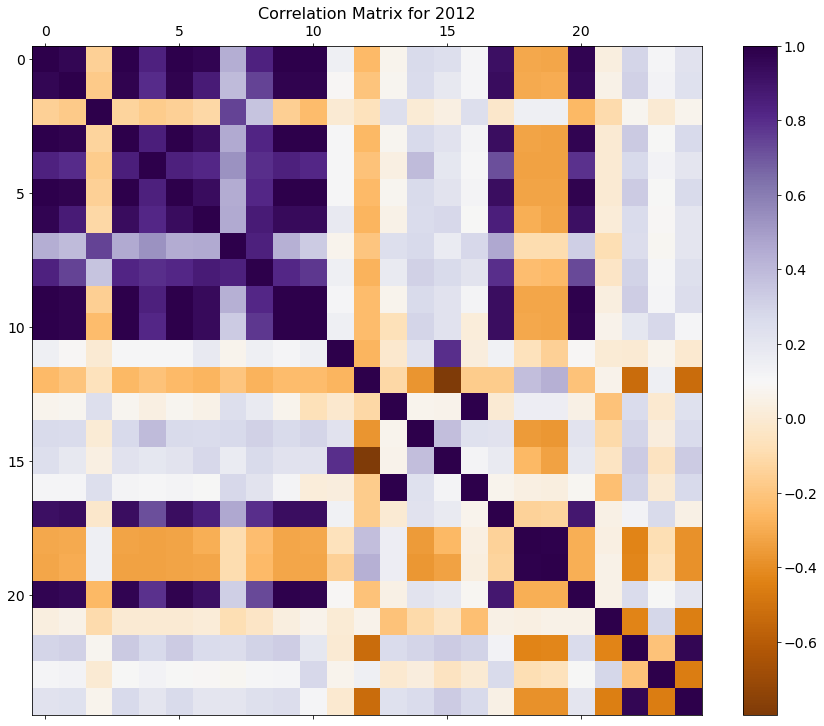

0: BIRTHS2012
1: DEATHS2012
2: DOMESTICMIG2012
3: EMPLOYED2012
4: INTERNATIONALMIG2012
5: LABOR_FORCE2012
6: NATURALINC2012
7: NETMIG2012
8: NPOPCHG_2012
9: POPESTIMATE2012
10: POP_CDC2012
11: RBIRTH2012
12: RDEATH2012
13: RDOMESTICMIG2012
14: RINTERNATIONALMIG2012
15: RNATURALINC2012
16: RNETMIG2012
17: SCDEATHS2012
18: SCRATE2012
19: SC_R_DEATH2012
20: UNEMPLOYED2012
21: UNEMPLOYMENT_RATE_PCT2012
22: mean_income__dollars2012
23: mean_to_median_household_income_ratio2012
24: median_income__dollars2012
Got 3407 rows for 2013


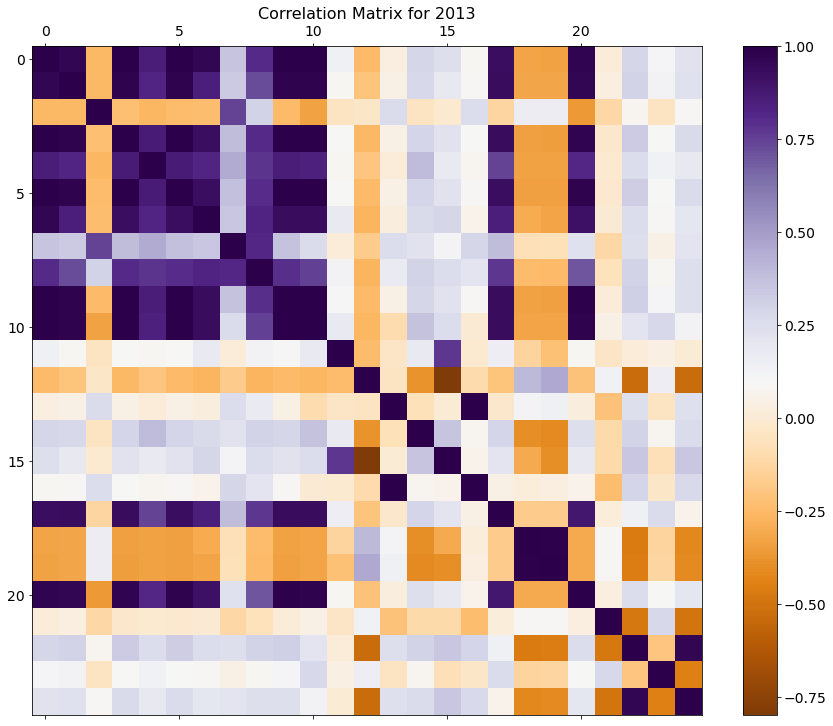

0: BIRTHS2013
1: DEATHS2013
2: DOMESTICMIG2013
3: EMPLOYED2013
4: INTERNATIONALMIG2013
5: LABOR_FORCE2013
6: NATURALINC2013
7: NETMIG2013
8: NPOPCHG_2013
9: POPESTIMATE2013
10: POP_CDC2013
11: RBIRTH2013
12: RDEATH2013
13: RDOMESTICMIG2013
14: RINTERNATIONALMIG2013
15: RNATURALINC2013
16: RNETMIG2013
17: SCDEATHS2013
18: SCRATE2013
19: SC_R_DEATH2013
20: UNEMPLOYED2013
21: UNEMPLOYMENT_RATE_PCT2013
22: mean_income__dollars2013
23: mean_to_median_household_income_ratio2013
24: median_income__dollars2013
Got 3407 rows for 2014


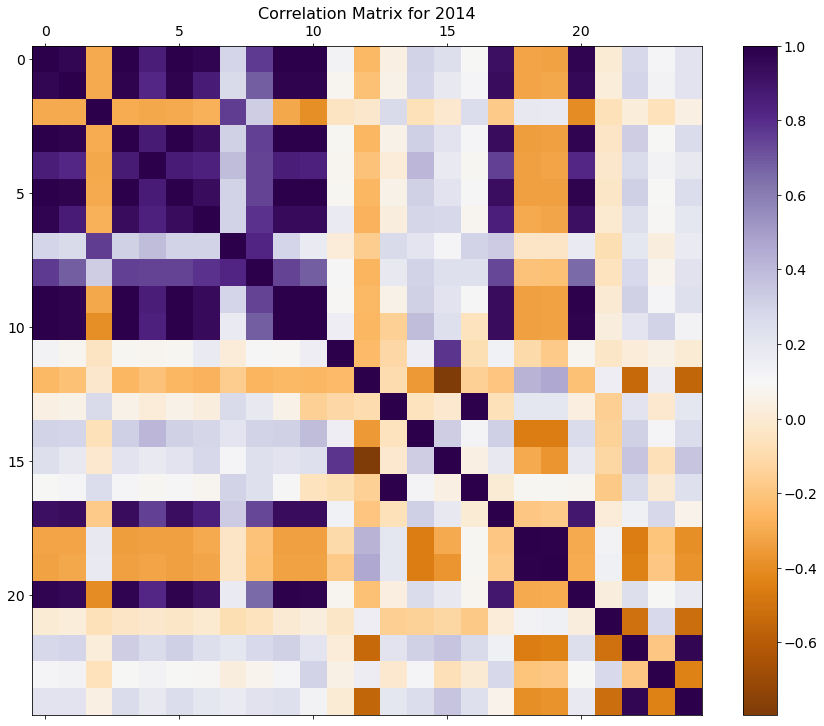

0: BIRTHS2014
1: DEATHS2014
2: DOMESTICMIG2014
3: EMPLOYED2014
4: INTERNATIONALMIG2014
5: LABOR_FORCE2014
6: NATURALINC2014
7: NETMIG2014
8: NPOPCHG_2014
9: POPESTIMATE2014
10: POP_CDC2014
11: RBIRTH2014
12: RDEATH2014
13: RDOMESTICMIG2014
14: RINTERNATIONALMIG2014
15: RNATURALINC2014
16: RNETMIG2014
17: SCDEATHS2014
18: SCRATE2014
19: SC_R_DEATH2014
20: UNEMPLOYED2014
21: UNEMPLOYMENT_RATE_PCT2014
22: mean_income__dollars2014
23: mean_to_median_household_income_ratio2014
24: median_income__dollars2014
Got 3407 rows for 2015


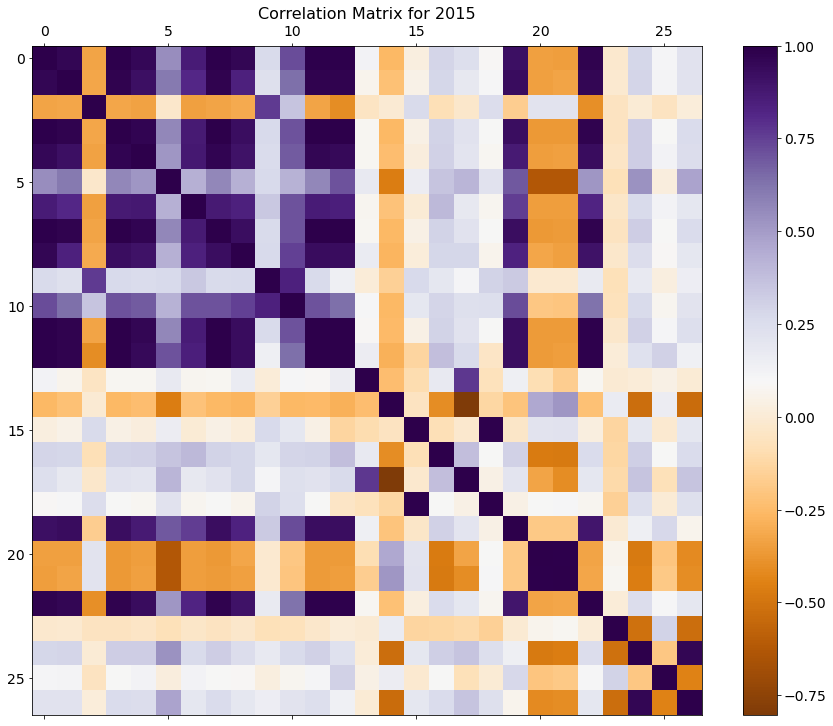

0: BIRTHS2015
1: DEATHS2015
2: DOMESTICMIG2015
3: EMPLOYED2015
4: GDP2015
5: GDP_LOG2015
6: INTERNATIONALMIG2015
7: LABOR_FORCE2015
8: NATURALINC2015
9: NETMIG2015
10: NPOPCHG_2015
11: POPESTIMATE2015
12: POP_CDC2015
13: RBIRTH2015
14: RDEATH2015
15: RDOMESTICMIG2015
16: RINTERNATIONALMIG2015
17: RNATURALINC2015
18: RNETMIG2015
19: SCDEATHS2015
20: SCRATE2015
21: SC_R_DEATH2015
22: UNEMPLOYED2015
23: UNEMPLOYMENT_RATE_PCT2015
24: mean_income__dollars2015
25: mean_to_median_household_income_ratio2015
26: median_income__dollars2015
Got 3407 rows for 2016


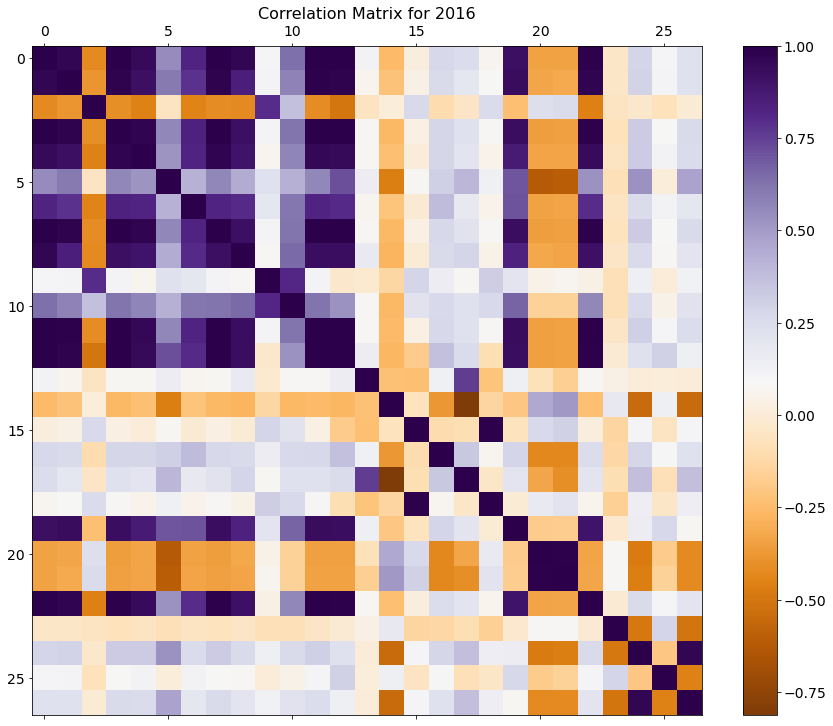

0: BIRTHS2016
1: DEATHS2016
2: DOMESTICMIG2016
3: EMPLOYED2016
4: GDP2016
5: GDP_LOG2016
6: INTERNATIONALMIG2016
7: LABOR_FORCE2016
8: NATURALINC2016
9: NETMIG2016
10: NPOPCHG_2016
11: POPESTIMATE2016
12: POP_CDC2016
13: RBIRTH2016
14: RDEATH2016
15: RDOMESTICMIG2016
16: RINTERNATIONALMIG2016
17: RNATURALINC2016
18: RNETMIG2016
19: SCDEATHS2016
20: SCRATE2016
21: SC_R_DEATH2016
22: UNEMPLOYED2016
23: UNEMPLOYMENT_RATE_PCT2016
24: mean_income__dollars2016
25: mean_to_median_household_income_ratio2016
26: median_income__dollars2016
Got 3407 rows for 2017


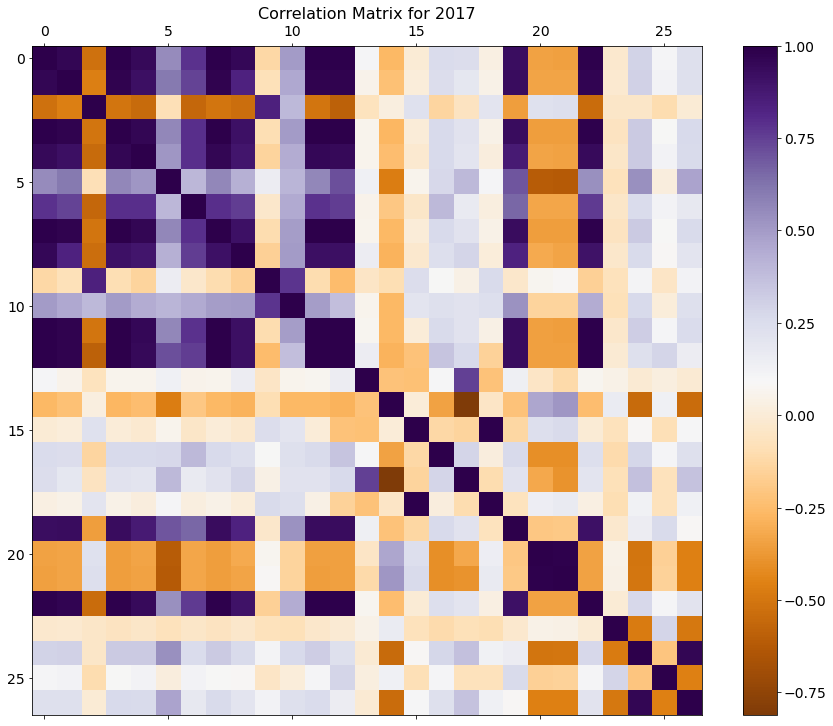

0: BIRTHS2017
1: DEATHS2017
2: DOMESTICMIG2017
3: EMPLOYED2017
4: GDP2017
5: GDP_LOG2017
6: INTERNATIONALMIG2017
7: LABOR_FORCE2017
8: NATURALINC2017
9: NETMIG2017
10: NPOPCHG_2017
11: POPESTIMATE2017
12: POP_CDC2017
13: RBIRTH2017
14: RDEATH2017
15: RDOMESTICMIG2017
16: RINTERNATIONALMIG2017
17: RNATURALINC2017
18: RNETMIG2017
19: SCDEATHS2017
20: SCRATE2017
21: SC_R_DEATH2017
22: UNEMPLOYED2017
23: UNEMPLOYMENT_RATE_PCT2017
24: mean_income__dollars2017
25: mean_to_median_household_income_ratio2017
26: median_income__dollars2017
Got 3407 rows for 2018


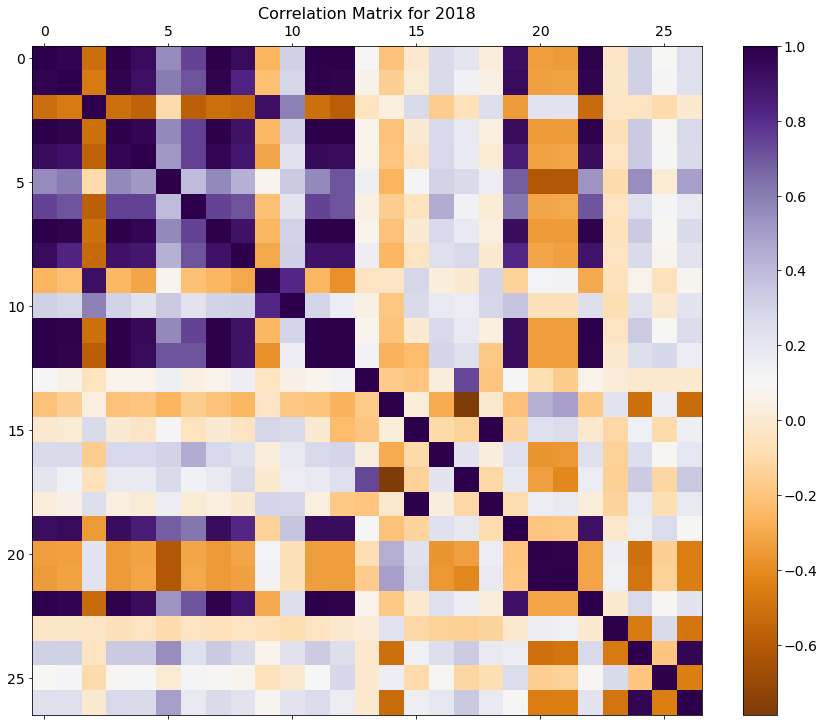

0: BIRTHS2018
1: DEATHS2018
2: DOMESTICMIG2018
3: EMPLOYED2018
4: GDP2018
5: GDP_LOG2018
6: INTERNATIONALMIG2018
7: LABOR_FORCE2018
8: NATURALINC2018
9: NETMIG2018
10: NPOPCHG_2018
11: POPESTIMATE2018
12: POP_CDC2018
13: RBIRTH2018
14: RDEATH2018
15: RDOMESTICMIG2018
16: RINTERNATIONALMIG2018
17: RNATURALINC2018
18: RNETMIG2018
19: SCDEATHS2018
20: SCRATE2018
21: SC_R_DEATH2018
22: UNEMPLOYED2018
23: UNEMPLOYMENT_RATE_PCT2018
24: mean_income__dollars2018
25: mean_to_median_household_income_ratio2018
26: median_income__dollars2018


In [12]:
%run ./mobilityHelpers.ipynb
helpers = mobilityHelpers()

for yy in range(2010, 2019):
    yyDF = hhi_gdp_pop_sc_emp_df[[cc for cc in hhi_gdp_pop_sc_emp_df if str(yy) in cc]].copy()
    #     for cc in yyDF.columns:
    #         yyDF[cc] = yyDF[cc].astype("float64")
    print(f"""Got {len(yyDF)} rows for {yy}""")
    helpers.plotCorrMatrix(yyDF, "Correlation Matrix for " + str(yy))
    for ii in range(len(yyDF.columns)):
        print(f"""{ii}: {list(yyDF.columns)[ii]}""")


In every year, there is a lot of multicollinearity.  

For some pairs of variables, it is expected mathematically: e.g., US Census population counts are measured only once in 10 years, and then model the rest based on migration and birth/death dynamics.  Suicide deaths ("SCDEATHS" in our dataset) will be correlated with death counts collected by the Census Bureau for each year ("DEATHS" in our dataset) and with suicide rate ("SCRATE").  Mean Household Income will be correlated with Median Household Income, although that correlation will vary by county.

For others, it is not expected mathematically, but logically sound: e.g., in 2018, suicide attempt rate ("SCRATE", variable 18) is strongly negatively correlated with mean (variable 20) and median household income (variable 22) and to a lesser degree with the economic disparity measured as "mean_to_median_household_income_ratio" (variable 21).

For still others, we have some surprises:  e.g., in 2018, suicide deaths ("SCDEATHS", variable 17) are positively correlated with domestic migration into the county ("DOMESTICMIG", variable 2) and with GDP (variable 3); at the same time these relationships are opposite for suicide attempt rate ("SCRATE", variable 18) and for suicide death rate ("SC_R_DEATH", variable 19).

Our variable of interest, net migration into the county ("NETMIG", variable 7), is very strongly positively correlated with GDP (variable 3) and very mildly negatively correlated with household income disparity (variable 18).  Interestingly, it is also negatively correlated with international migration into the county ("INTERNATIONALMIG", variable 5), number of births in the county ("BIRTHS", variable 0), and household income (variables 17 and 19) in the target county and positively with domestic migration ("DOMESTICMIG", variable 2).

***TODO: Express verbally what else we see in the correlation matrix plots***

To avoid data leakage and perfect accuracy (meaning model is overfitted), we need to do the following:

1. Perform PCA to combine variables into principal components
2. Identify top N principal components based on their contribution to variance (CTV)
3. Build predictive models

In [13]:
hhi_gdp_pop_sc_emp_long.head()

,county,county_state,metric,state,value,year,metric_year
0,Autauga,"Autauga, Alabama",GDP,Alabama,1518409.0,2015,GDP2015
1,Baldwin,"Baldwin, Alabama",GDP,Alabama,5345363.0,2015,GDP2015
2,Barbour,"Barbour, Alabama",GDP,Alabama,756590.0,2015,GDP2015
3,Bibb,"Bibb, Alabama",GDP,Alabama,358372.0,2015,GDP2015
4,Blount,"Blount, Alabama",GDP,Alabama,824934.0,2015,GDP2015


Do the same correlation analysis including the year:

In [14]:
# del hhi_gdp_pop_sc_long["metric_year"]
hhi_gdp_pop_sc_emp_yr_df = hhi_gdp_pop_sc_emp_long.pivot_table(index=["county_state", "year"],
                                                    columns=["metric"],
                                                    values=["value"]).reset_index(drop=False)
cols = ["county_state"]
cols.extend(["year"])
cols.extend(list(hhi_gdp_pop_sc_emp_yr_df.columns.levels[1][:-1]))


hhi_gdp_pop_sc_emp_yr_df.columns = cols

hhi_gdp_pop_sc_emp_yr_df.year = hhi_gdp_pop_sc_emp_yr_df.year.astype("float64")
hhi_gdp_pop_sc_emp_yr_df.reset_index(drop=True, inplace=True)

print(hhi_gdp_pop_sc_emp_yr_df.dtypes)

hhi_gdp_pop_sc_emp_yr_df.head()

county_state                              object
year                                     float64
BIRTHS                                   float64
CENSUSPOP                                float64
DEATHS                                   float64
DOMESTICMIG                              float64
EMPLOYED                                 float64
ESTIMATESBASE                            float64
GDP                                      float64
GDP_LOG                                  float64
INTERNATIONALMIG                         float64
LABOR_FORCE                              float64
NATURALINC                               float64
NETMIG                                   float64
NPOPCHG_                                 float64
POPESTIMATE                              float64
POP_CDC                                  float64
RBIRTH                                   float64
RDEATH                                   float64
RDOMESTICMIG                             float64
RINTERNATIONALMIG   

,county_state,year,BIRTHS,CENSUSPOP,DEATHS,DOMESTICMIG,EMPLOYED,ESTIMATESBASE,GDP,GDP_LOG,...,RNATURALINC,RNETMIG,SCDEATHS,SCRATE,SC_R_DEATH,UNEMPLOYED,UNEMPLOYMENT_RATE_PCT,mean_income__dollars,mean_to_median_household_income_ratio,median_income__dollars
0,"Abbeville, South Carolina",2000.0,NaN,NaN,NaN,NaN,12119.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,483.0,3.8,NaN,NaN,NaN
1,"Abbeville, South Carolina",2001.0,NaN,NaN,NaN,NaN,11491.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,811.0,6.6,NaN,NaN,NaN
2,"Abbeville, South Carolina",2002.0,NaN,NaN,NaN,NaN,10889.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,907.0,7.7,NaN,NaN,NaN
3,"Abbeville, South Carolina",2003.0,NaN,NaN,NaN,NaN,10736.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1077.0,9.1,NaN,NaN,NaN
4,"Abbeville, South Carolina",2004.0,NaN,NaN,NaN,NaN,10955.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,979.0,8.2,NaN,NaN,NaN


Build a linear-correlation matrix:

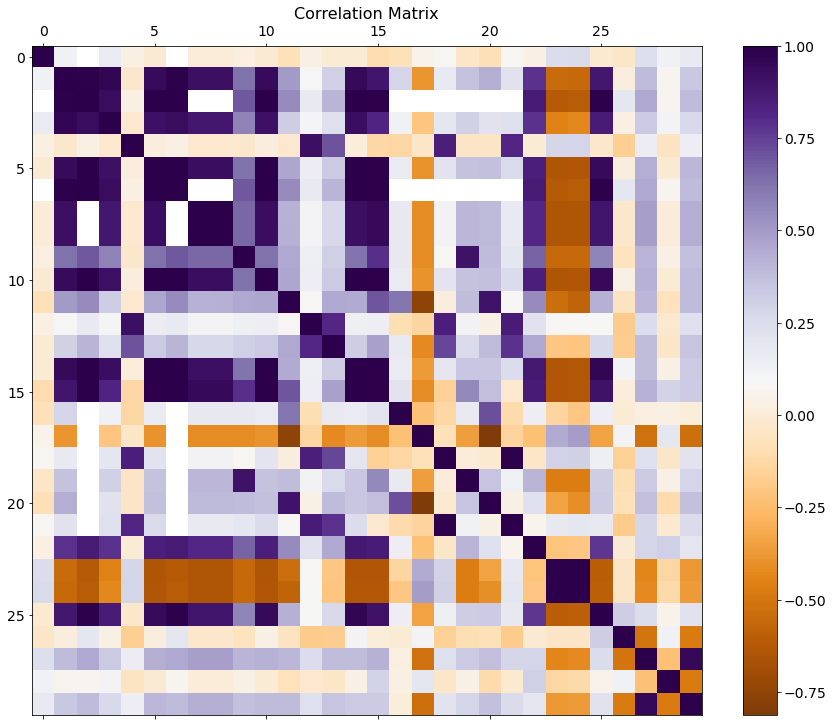

0: year
1: BIRTHS
2: CENSUSPOP
3: DEATHS
4: DOMESTICMIG
5: EMPLOYED
6: ESTIMATESBASE
7: GDP
8: GDP_LOG
9: INTERNATIONALMIG
10: LABOR_FORCE
11: NATURALINC
12: NETMIG
13: NPOPCHG_
14: POPESTIMATE
15: POP_CDC
16: RBIRTH
17: RDEATH
18: RDOMESTICMIG
19: RINTERNATIONALMIG
20: RNATURALINC
21: RNETMIG
22: SCDEATHS
23: SCRATE
24: SC_R_DEATH
25: UNEMPLOYED
26: UNEMPLOYMENT_RATE_PCT
27: mean_income__dollars
28: mean_to_median_household_income_ratio
29: median_income__dollars


,year,BIRTHS,CENSUSPOP,DEATHS,DOMESTICMIG,EMPLOYED,ESTIMATESBASE,GDP,GDP_LOG,INTERNATIONALMIG,...,RNATURALINC,RNETMIG,SCDEATHS,SCRATE,SC_R_DEATH,UNEMPLOYED,UNEMPLOYMENT_RATE_PCT,mean_income__dollars,mean_to_median_household_income_ratio,median_income__dollars
0,2000.0,NaN,NaN,NaN,NaN,12119.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,483.0,3.8,NaN,NaN,NaN
1,2001.0,NaN,NaN,NaN,NaN,11491.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,811.0,6.6,NaN,NaN,NaN
2,2002.0,NaN,NaN,NaN,NaN,10889.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,907.0,7.7,NaN,NaN,NaN
3,2003.0,NaN,NaN,NaN,NaN,10736.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1077.0,9.1,NaN,NaN,NaN
4,2004.0,NaN,NaN,NaN,NaN,10955.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,979.0,8.2,NaN,NaN,NaN


In [15]:
%run ./mobilityHelpers.ipynb
helpers = mobilityHelpers()

hhi_gdp_pop_sc_emp_yr_correl = hhi_gdp_pop_sc_emp_yr_df.copy()
del hhi_gdp_pop_sc_emp_yr_correl["county_state"]

helpers.plotCorrMatrix(hhi_gdp_pop_sc_emp_yr_correl, "Correlation Matrix", method="spearman")
for ii in range(len(hhi_gdp_pop_sc_emp_yr_correl.columns)):
    print(f"""{ii}: {list(hhi_gdp_pop_sc_emp_yr_correl.columns)[ii]}""")
hhi_gdp_pop_sc_emp_yr_correl.head()

Build a monotonic-correlation matrix:

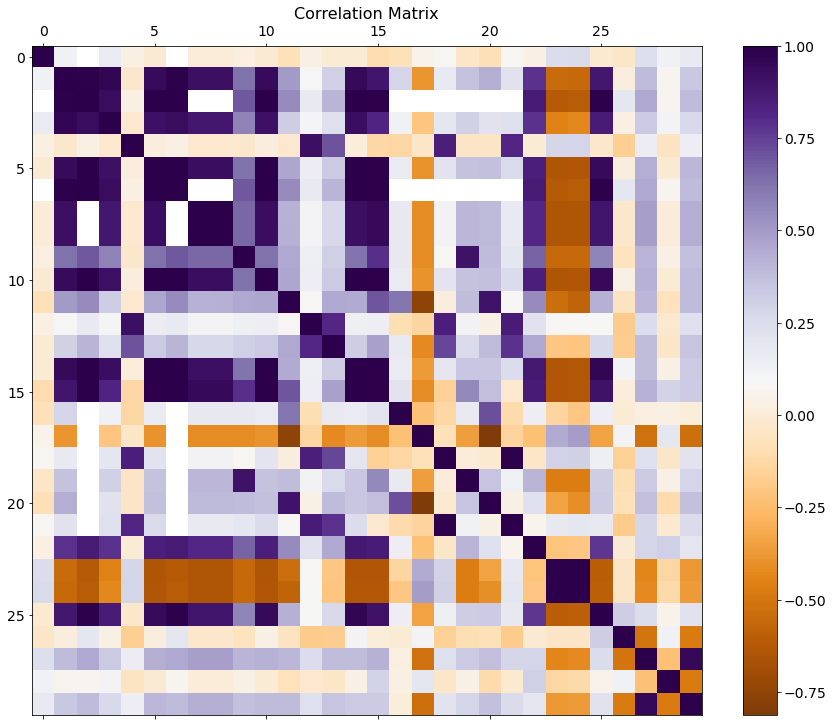

0: year
1: BIRTHS
2: CENSUSPOP
3: DEATHS
4: DOMESTICMIG
5: EMPLOYED
6: ESTIMATESBASE
7: GDP
8: GDP_LOG
9: INTERNATIONALMIG
10: LABOR_FORCE
11: NATURALINC
12: NETMIG
13: NPOPCHG_
14: POPESTIMATE
15: POP_CDC
16: RBIRTH
17: RDEATH
18: RDOMESTICMIG
19: RINTERNATIONALMIG
20: RNATURALINC
21: RNETMIG
22: SCDEATHS
23: SCRATE
24: SC_R_DEATH
25: UNEMPLOYED
26: UNEMPLOYMENT_RATE_PCT
27: mean_income__dollars
28: mean_to_median_household_income_ratio
29: median_income__dollars


,year,BIRTHS,CENSUSPOP,DEATHS,DOMESTICMIG,EMPLOYED,ESTIMATESBASE,GDP,GDP_LOG,INTERNATIONALMIG,...,RNATURALINC,RNETMIG,SCDEATHS,SCRATE,SC_R_DEATH,UNEMPLOYED,UNEMPLOYMENT_RATE_PCT,mean_income__dollars,mean_to_median_household_income_ratio,median_income__dollars
0,2000.0,NaN,NaN,NaN,NaN,12119.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,483.0,3.8,NaN,NaN,NaN
1,2001.0,NaN,NaN,NaN,NaN,11491.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,811.0,6.6,NaN,NaN,NaN
2,2002.0,NaN,NaN,NaN,NaN,10889.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,907.0,7.7,NaN,NaN,NaN
3,2003.0,NaN,NaN,NaN,NaN,10736.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1077.0,9.1,NaN,NaN,NaN
4,2004.0,NaN,NaN,NaN,NaN,10955.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,979.0,8.2,NaN,NaN,NaN


In [16]:
%run ./mobilityHelpers.ipynb
helpers = mobilityHelpers()

hhi_gdp_pop_sc_emp_yr_correl = hhi_gdp_pop_sc_emp_yr_df.copy()
del hhi_gdp_pop_sc_emp_yr_correl["county_state"]

helpers.plotCorrMatrix(hhi_gdp_pop_sc_emp_yr_correl, "Correlation Matrix", method="spearman")
for ii in range(len(hhi_gdp_pop_sc_emp_yr_correl.columns)):
    print(f"""{ii}: {list(hhi_gdp_pop_sc_emp_yr_correl.columns)[ii]}""")
hhi_gdp_pop_sc_emp_yr_correl.head()

We have 30x30 features, which is potentially 900 correlations.  We are only interested in those that are correlated with the target variables: NETMIG, DOMESTICMIG, and INTERNATIONALMIG

In [19]:
matCorr = hhi_gdp_pop_sc_emp_yr_correl.corr()

corrDF = matCorr.stack(dropna=True).reset_index()
corrDF.columns = ["feature_1", "feature_2", "correlation"]
correlated_features = \
    corrDF[(abs(corrDF["correlation"]) > 0.25) & \
           (abs(corrDF["correlation"]) != 1.0)].copy().reset_index(drop=True)

# correlated_features.sort_values("correlation", inplace=True).reset_index(drop=True)
correlated_features

,feature_1,feature_2,correlation
0,year,SC_R_DEATH,0.251364
1,BIRTHS,CENSUSPOP,0.992833
2,BIRTHS,DEATHS,0.960296
3,BIRTHS,DOMESTICMIG,-0.378249
4,BIRTHS,EMPLOYED,0.961687
...,...,...,...
405,median_income__dollars,SCRATE,-0.381187
406,median_income__dollars,SC_R_DEATH,-0.373256
407,median_income__dollars,UNEMPLOYMENT_RATE_PCT,-0.465156
408,median_income__dollars,mean_income__dollars,0.960141


Check correlation between different sources of population estimate

In [22]:
pop_corr = \
    correlated_features.loc[(correlated_features["feature_1"].str.contains("POP"))
                        & (correlated_features["feature_2"].str.contains("POP"))]
pop_corr.sort_values("correlation")

,feature_1,feature_2,correlation
218,NPOPCHG_,POP_CDC,0.564596
253,POP_CDC,NPOPCHG_,0.564596
217,NPOPCHG_,POPESTIMATE,0.612064
235,POPESTIMATE,NPOPCHG_,0.612064
28,CENSUSPOP,NPOPCHG_,0.659576
206,NPOPCHG_,CENSUSPOP,0.659576
236,POPESTIMATE,POP_CDC,0.999987
254,POP_CDC,POPESTIMATE,0.999987
29,CENSUSPOP,POPESTIMATE,0.999998
225,POPESTIMATE,CENSUSPOP,0.999998


We see that POPESTIMATE, POP_CDC, CENSUSPOP are all closely correlated; for further analysis, we might as well remove all but one - or we can wait for PCA (Principal Component Analysis) to do it for us.

In [25]:
tgtCorr = matCorr[["NETMIG", "DOMESTICMIG", "INTERNATIONALMIG"]].copy()
tgtCorr = tgtCorr.loc[[ii for ii in list(tgtCorr.index) if 'MIG' not in ii]].copy()

tgtCorrTr = pd.DataFrame(tgtCorr.dropna().T)
# tgtCorrTr.column = list(tgtCorr.index)

Columns:
0: NETMIG
1: DOMESTICMIG
2: INTERNATIONALMIG


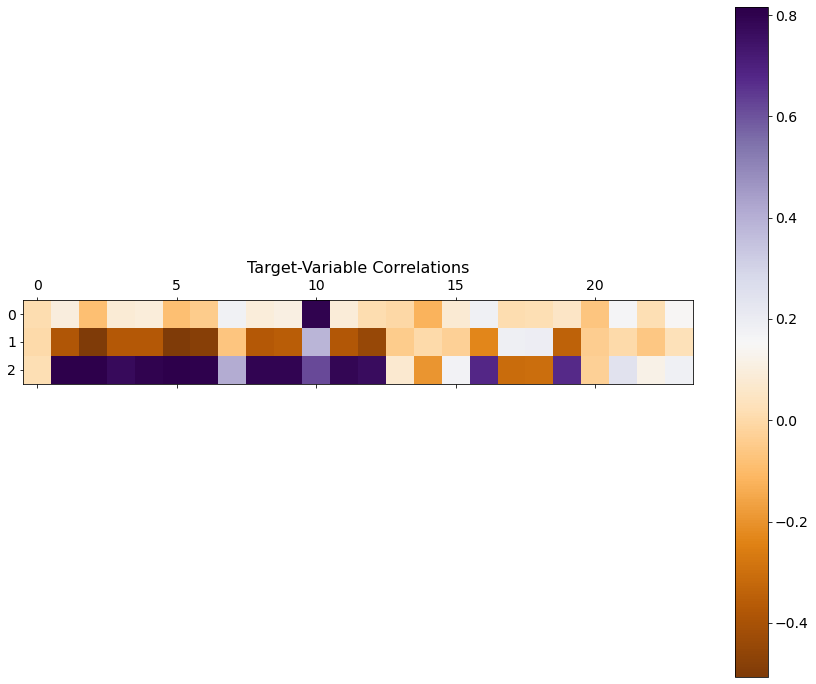

Rows:
0: year
1: BIRTHS
2: CENSUSPOP
3: DEATHS
4: EMPLOYED
5: ESTIMATESBASE
6: GDP
7: GDP_LOG
8: LABOR_FORCE
9: NATURALINC
10: NPOPCHG_
11: POPESTIMATE
12: POP_CDC
13: RBIRTH
14: RDEATH
15: RNATURALINC
16: SCDEATHS
17: SCRATE
18: SC_R_DEATH
19: UNEMPLOYED
20: UNEMPLOYMENT_RATE_PCT
21: mean_income__dollars
22: mean_to_median_household_income_ratio
23: median_income__dollars


In [27]:
print("Columns:")
for ii in range(len(tgtCorrTr.index)):
    print(f"""{ii}: {tgtCorrTr.index[ii]}""")
helpers.plotGivenCorrMatrix(tgtCorr.dropna().T, "Target-Variable Correlations")

colnames = list(tgtCorr.index)
tgtCorrTr.columns = colnames

print("Rows:")
for ii in range(len(tgtCorrTr.columns)):
    print(f"""{ii}: {tgtCorrTr.columns[ii]}""")

We see that there is a slight negative correlation with time for all metrics, but it is mostly irrelevant.  A more interesting observation is the counteracting effect of all features on international and domestic migraion: features positively correlated with one are negatively correlated with the other

In [33]:
tgtCorrDF = tgtCorr.stack(dropna=True).reset_index()
tgtCorrDF.columns = ["feature_1", "feature_2", "correlation"]
tgt_correlated_features = \
    tgtCorrDF[(abs(tgtCorrDF["correlation"]) > 0.15) & \
           (abs(tgtCorrDF["correlation"]) != 1.0)].copy().reset_index(drop=True)

tgt_correlated_features.sort_values("correlation").reset_index(drop=True)

,feature_1,feature_2,correlation
0,ESTIMATESBASE,DOMESTICMIG,-0.506583
1,CENSUSPOP,DOMESTICMIG,-0.506557
2,GDP,DOMESTICMIG,-0.483079
3,POP_CDC,DOMESTICMIG,-0.440742
4,BIRTHS,DOMESTICMIG,-0.378249
5,POPESTIMATE,DOMESTICMIG,-0.374290
6,LABOR_FORCE,DOMESTICMIG,-0.371725
7,EMPLOYED,DOMESTICMIG,-0.371692
8,DEATHS,DOMESTICMIG,-0.369002
9,NATURALINC,DOMESTICMIG,-0.355097


NET Migration

In [90]:
helpers.analyzeCorr4Migrations(tgt_correlated_features, "NETMIG")


-------------------------------------------
NETMIG into US counties is negatively correlated with:


-------------------------------------------
NETMIG into US counties is positively correlated with:

mean_income__dollars
GDP_LOG
SCDEATHS
NPOPCHG_


,feature_1,feature_2,correlation
0,mean_income__dollars,NETMIG,0.164445
1,GDP_LOG,NETMIG,0.180016
2,SCDEATHS,NETMIG,0.180821
3,NPOPCHG_,NETMIG,0.796717


DOMESTIC Migration

In [91]:
helpers.analyzeCorr4Migrations(tgt_correlated_features, "DOMESTICMIG")


-------------------------------------------
DOMESTICMIG into US counties is negatively correlated with:

ESTIMATESBASE
CENSUSPOP
GDP
POP_CDC
BIRTHS
POPESTIMATE
LABOR_FORCE
EMPLOYED
DEATHS
NATURALINC
UNEMPLOYED
SCDEATHS

-------------------------------------------
DOMESTICMIG into US counties is positively correlated with:

SCRATE
SC_R_DEATH
NPOPCHG_


,feature_1,feature_2,correlation
0,ESTIMATESBASE,DOMESTICMIG,-0.506583
1,CENSUSPOP,DOMESTICMIG,-0.506557
2,GDP,DOMESTICMIG,-0.483079
3,POP_CDC,DOMESTICMIG,-0.440742
4,BIRTHS,DOMESTICMIG,-0.378249
5,POPESTIMATE,DOMESTICMIG,-0.374290
6,LABOR_FORCE,DOMESTICMIG,-0.371725
7,EMPLOYED,DOMESTICMIG,-0.371692
8,DEATHS,DOMESTICMIG,-0.369002
9,NATURALINC,DOMESTICMIG,-0.355097


In [92]:
helpers.analyzeCorr4Migrations(tgt_correlated_features, "INTERNATIONALMIG")


-------------------------------------------
INTERNATIONALMIG into US counties is negatively correlated with:

SCRATE
SC_R_DEATH
RDEATH

-------------------------------------------
INTERNATIONALMIG into US counties is positively correlated with:

RNATURALINC
median_income__dollars
mean_income__dollars
GDP_LOG
NPOPCHG_
UNEMPLOYED
SCDEATHS
POP_CDC
DEATHS
POPESTIMATE
NATURALINC
LABOR_FORCE
EMPLOYED
GDP
CENSUSPOP
ESTIMATESBASE
BIRTHS


,feature_1,feature_2,correlation
0,SCRATE,INTERNATIONALMIG,-0.308604
1,SC_R_DEATH,INTERNATIONALMIG,-0.305001
2,RDEATH,INTERNATIONALMIG,-0.193278
3,RNATURALINC,INTERNATIONALMIG,0.172757
4,median_income__dollars,INTERNATIONALMIG,0.181767
5,mean_income__dollars,INTERNATIONALMIG,0.245445
6,GDP_LOG,INTERNATIONALMIG,0.411359
7,NPOPCHG_,INTERNATIONALMIG,0.614584
8,UNEMPLOYED,INTERNATIONALMIG,0.672202
9,SCDEATHS,INTERNATIONALMIG,0.676986


International migration seems to be a more complex phenomenon than domestic migration

In [93]:
csv_out = MYDIR + "hhi_gdp_pop_sc_emp__preparing_for_modeling.csv"
hhi_gdp_pop_sc_emp_df.to_csv(csv_out, index=False)
print(f"""Saved the prepared data to {csv_out}""")

csv_out_long = MYDIR + "hhi_gdp_pop_sc_emp_long__preparing_for_modeling.csv"
hhi_gdp_pop_sc_emp_long.to_csv(csv_out_long, index=False)
print(f"""Saved the prepared data in the long form to {csv_out_long}""")

csv_out_yr = MYDIR + "hhi_gdp_pop_sc_emp_yr__preparing_for_modeling.csv"
hhi_gdp_pop_sc_emp_yr_df.to_csv(csv_out_yr, index=False)
print(f"""Saved the prepared data to {csv_out_yr}""")


Saved the prepared data to ./../../ResearchProposal/hhi_gdp_pop_sc_emp__preparing_for_modeling.csv
Saved the prepared data in the long form to ./../../ResearchProposal/hhi_gdp_pop_sc_emp_long__preparing_for_modeling.csv
Saved the prepared data to ./../../ResearchProposal/hhi_gdp_pop_sc_emp_yr__preparing_for_modeling.csv


In [43]:
# import pandas_profiling
# hhi_gdp_pop_sc_emp_yr_df.profile_report()